# 타이타닉 생존자 예측
- 타이타닉 => 생존자 예측
- 문자로 데이터 구성
- 결측치 꽤 많음 + 문화권 영향

베이스라인 : R/F -> CatBoost, XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import mglearn
import sklearn
from sklearn.cluster import KMeans, DBSCAN

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("./data/titanic_train.csv")
test = pd.read_csv("./data/titanic_test.csv")

## 결측치

In [3]:
train["Age"] = train["Age"].fillna(train["Age"].median())
train["Embarked"] = train["Embarked"].fillna("S")

# test도 잊지 않기!
test["Age"] = test["Age"].fillna(test["Age"].median())
test["Fare"] = test["Fare"].fillna(test["Fare"].median())

'평균'을 쓰지 말고 '중위값'을 이용하는 편이 좋다

In [4]:
print(train.isnull().sum())
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 숫자로 변경

In [6]:
train["Sex"][train["Sex"]=="male"] = 0
train["Sex"][train["Sex"]=="female"] = 1
test["Sex"][test["Sex"]=="male"] = 0
test["Sex"][test["Sex"]=="female"] = 1

train["Embarked"][train["Embarked"]=="S"] = 0
train["Embarked"][train["Embarked"]=="C"] = 1
train["Embarked"][train["Embarked"]=="Q"] = 2
test["Embarked"][test["Embarked"]=="S"] = 0
test["Embarked"][test["Embarked"]=="C"] = 1
test["Embarked"][test["Embarked"]=="Q"] = 2

In [7]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,NaN,0
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,B42,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,28.0,1,2,W./C. 6607,23.4500,NaN,0
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,C148,1


## 데이터 나누기

In [8]:
X = train.drop(["Survived","Name","Ticket","Cabin"],axis=1)
y = train["Survived"]

In [9]:
X, y

(     PassengerId  Pclass Sex   Age  SibSp  Parch     Fare Embarked
 0              1       3   0  22.0      1      0   7.2500        0
 1              2       1   1  38.0      1      0  71.2833        1
 2              3       3   1  26.0      0      0   7.9250        0
 3              4       1   1  35.0      1      0  53.1000        0
 4              5       3   0  35.0      0      0   8.0500        0
 ..           ...     ...  ..   ...    ...    ...      ...      ...
 886          887       2   0  27.0      0      0  13.0000        0
 887          888       1   1  19.0      0      0  30.0000        0
 888          889       3   1  28.0      1      2  23.4500        0
 889          890       1   0  26.0      0      0  30.0000        1
 890          891       3   0  32.0      0      0   7.7500        2
 
 [891 rows x 8 columns],
 0      0
 1      1
 2      1
 3      1
 4      0
       ..
 886    0
 887    1
 888    0
 889    1
 890    0
 Name: Survived, Length: 891, dtype: int64)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [11]:
X_train = X_train.astype("float")
X_test = X_test.astype("float")
y_train = y_train.astype("float")
y_test = y_test.astype("float")

In [12]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [13]:
params = {
        "objective":["binary:logistic"],
         "booster":["gbtree"], #일반적으로 gbtree 쓰라고 제시됨
         "eta":[0.01],
         "max_depth": [0,1,2,3,4,5,6,7,8,9,10],
          "min_child_weight":[0,1,2,3,4,5,6,7,8,9,10],
          "colsample_bytree":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
          "subsample":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
          "alpha": [0,1,2,3,4,5],
          "lambda":[0,1,2,3,4,5],
          "n_estimators":[80000],
          "random_state":[42]
        }

In [14]:
clf = xgb.XGBClassifier()
clf_grid = RandomizedSearchCV(clf,
                             params,
                             cv=5,
                             n_iter=50,
                             random_state=42,
                             scoring="accuracy")

In [15]:
clf_grid.fit(X_train, y_train,
             early_stopping_rounds=70, #50번 넘도록 나를 못넘으면 멈춰라
             eval_set = [(X_test,y_test)],
             eval_metric = "error",
             verbose = 0)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'booster': ['gbtree'],
                                        'colsample_bytree': [0.1, 0.2, 0.3, 0.4,
                                                             0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1.0],
                                        'eta': [0.01],
                                        'lambda': [0, 1, 2, 3, 4, 5],
                                        'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10],
                                        'min_child_weight': [0, 1, 2, 3, 4, 5,
                                                             6, 7, 8, 9, 10],
                                        'n_estimators': [80000],
                                        'objective': ['binary:logistic'],
                                        'random_state': [42],
                                        'subsample': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                      0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   random_state=42, scoring='accuracy')

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(clf_grid.best_params_)
print(clf_grid.best_score_)

{'subsample': 0.6, 'random_state': 42, 'objective': 'binary:logistic', 'n_estimators': 80000, 'min_child_weight': 0, 'max_depth': 8, 'lambda': 1, 'eta': 0.01, 'colsample_bytree': 1.0, 'booster': 'gbtree', 'alpha': 0}
0.8128605094826618


In [17]:
bst = clf_grid.best_estimator_
print(bst)

XGBClassifier(alpha=0, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=0, missing=nan,
              monotone_constraints=None, multi_strategy=None,
              n_estimators=80000, ...)


In [18]:
pred_1 = bst.predict(X_test)
grid_score = accuracy_score(y_test, pred_1)
print(grid_score)

0.8340807174887892


In [19]:
confusion_matrix(y_test,pred_1)

array([[125,   9],
       [ 28,  61]], dtype=int64)

In [20]:
def plot_f_importances(model):
    n_f = X.shape[1]
    plt.barh(range(n_f), model.feature_importances_, align="center")
    plt.yticks(np.arange(n_f),X)
    plt.show()

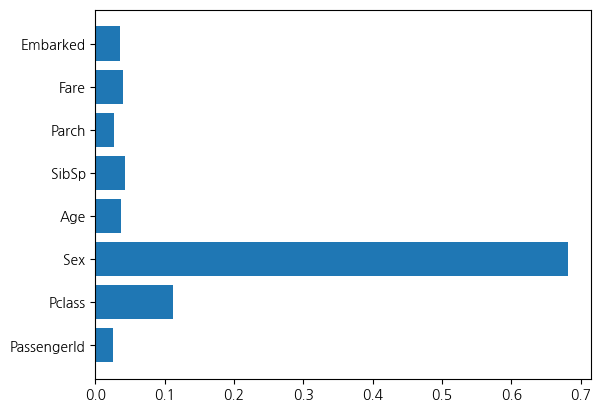

In [21]:
plot_f_importances(bst)

In [22]:
X=test.drop(["Name","Ticket","Cabin"],axis=1)
X=X.astype("float")
Y=bst.predict(X)
Y=np.array(Y,dtype="int64")
print(Y)

[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 0 1 1 0 0 1 0 0 0]


In [23]:
PassengerId = np.array(test["PassengerId"]).astype(int)
result = pd.DataFrame(Y,PassengerId,columns=["Survived"])

In [24]:
# result.to_csv("submission.csv",index_label=["PassengerId"])